### Face Entity Recognition (FER)

#### In this code, I'll be:
- Segmenting the video to frames, taking *n* frames per second.
- Performing face detection, in order to apply the facial analysis.
- Integrating facial analysis on the data, in order to detect the facial emotion.

In [1]:
# Libraries

import torch
from facenet_pytorch import MTCNN
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, AutoConfig
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from moviepy.editor import VideoFileClip, ImageSequenceClip
from tqdm import tqdm
import pandas as pd
import numpy as np


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load face detector and models
mtcnn = MTCNN(keep_all=True, device='cpu')  # Integration issue in Cuda:0, therefore, it's run with CPU
extractor = AutoFeatureExtractor.from_pretrained("trpakov/vit-face-expression")
model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression").to(device)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")

# Modify id2label to reclassify certain emotions as 'others'
id2label = {i: 'others' if label in ['fear', 'surprise', 'disgust'] else label for i, label in config.id2label.items()}

True


In [3]:
# Functions

def detect_and_analyze_emotions(frame):
    frame_pil = Image.fromarray(frame) if not isinstance(frame, Image.Image) else frame.convert('RGB')
    boxes, _ = mtcnn.detect(frame_pil)
    results = []
    if boxes is not None:
        for box in boxes:
            face = frame_pil.crop((box[0], box[1], box[2], box[3]))
            inputs = extractor(images=face, return_tensors="pt").to(device)
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            probabilities = probabilities.detach().cpu().numpy().tolist()[0]
            class_probabilities = {id2label[i]: prob for i, prob in enumerate(probabilities)}
            results.append((face, class_probabilities))
    return results

def create_combined_image(face, class_probabilities):
    face_array = np.array(face)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(face_array)
    axs[0].axis('off')
    palette = [sns.color_palette()[i % len(sns.color_palette())] for i in range(len(class_probabilities))]
    sns.barplot(ax=axs[1], x=list(class_probabilities.keys()), 
                y=[prob * 100 for prob in class_probabilities.values()],
                palette=palette)
    axs[1].set_ylabel('Probability (%)')
    fig.canvas.draw()
    combined_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    combined_image = combined_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return combined_image

def plot_and_save_emotion_distribution(all_class_probabilities):
    df = pd.DataFrame(all_class_probabilities)
    emotion_counts = df.sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 8))
    plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Total Emotion Distribution in Video')
    plt.savefig('output/emotion_distribution_pie_chart.png', format='png', bbox_inches='tight')
    plt.show()

# Process the video
def process_video(scene, frames_per_second):
    clip = VideoFileClip(scene).without_audio()
    vid_fps = clip.fps
    video_duration = clip.duration
    frame_interval = int(vid_fps / frames_per_second)

    all_class_probabilities = []
    combined_images = []

    for frame_number, frame in enumerate(tqdm(clip.iter_frames(), total=int(video_duration * frames_per_second), desc="Processing Video")):
        if frame_number % frame_interval == 0:
            frame_results = detect_and_analyze_emotions(frame)
            for face, class_probabilities in frame_results:
                all_class_probabilities.append(class_probabilities)
                combined_image = create_combined_image(face, class_probabilities)
                combined_images.append(combined_image)

    # Debug: Check if all images are of the same size
    if all(image.shape == combined_images[0].shape for image in combined_images):
        print("All images are of the same size.")
    else:
        print("Warning: Image sizes are not consistent.")

    output_clip = ImageSequenceClip(combined_images, fps=frames_per_second or 24)  # Default to 24 fps if fps is None
    output_clip.write_videofile("output/output_video.mp4", codec='libx264')

    plot_and_save_emotion_distribution(all_class_probabilities)
    return all_class_probabilities

Processing Video: 3223it [02:40, 20.06it/s]                        


All images are of the same size.
Moviepy - Building video output/output_video.mp4.
Moviepy - Writing video output/output_video.mp4



Moviepy - Done !
Moviepy - video ready output/output_video.mp4


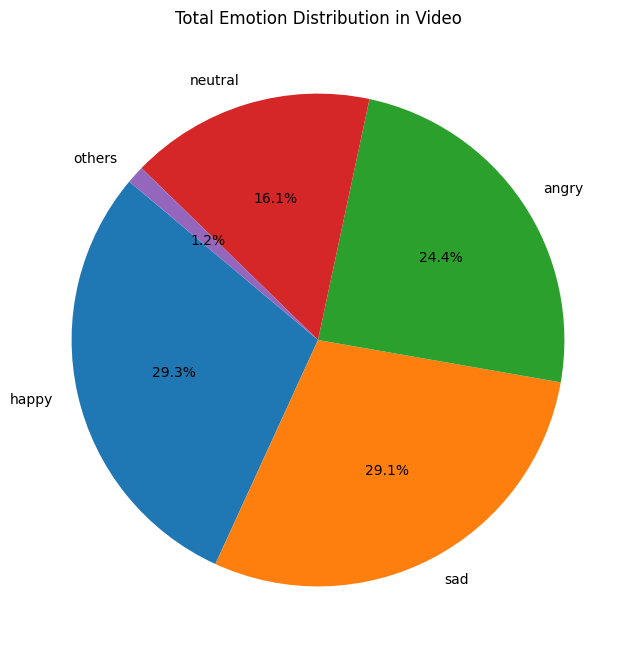

In [4]:
# Running the code

probabilities = process_video('../TobyReturns.mp4', 1)

In [5]:
probabilities
dominant_emotions = [max(emotions, key=emotions.get) for emotions in probabilities]
dominant_emotions

['sad',
 'angry',
 'angry',
 'sad',
 'sad',
 'happy',
 'happy',
 'sad',
 'sad',
 'sad',
 'sad',
 'angry',
 'sad',
 'sad',
 'sad',
 'neutral',
 'happy',
 'sad',
 'happy',
 'happy',
 'neutral',
 'others',
 'happy',
 'angry',
 'happy',
 'happy',
 'sad',
 'happy',
 'sad',
 'sad',
 'sad',
 'angry',
 'sad',
 'sad',
 'sad',
 'sad',
 'neutral',
 'angry',
 'angry',
 'neutral',
 'sad',
 'happy',
 'angry',
 'sad',
 'angry',
 'sad',
 'happy',
 'angry',
 'happy',
 'sad',
 'happy',
 'neutral',
 'sad',
 'neutral',
 'happy',
 'neutral',
 'sad',
 'sad',
 'angry',
 'neutral',
 'neutral',
 'neutral',
 'angry',
 'sad',
 'neutral',
 'neutral',
 'angry',
 'angry',
 'angry',
 'neutral',
 'happy',
 'angry',
 'angry',
 'angry',
 'sad',
 'sad',
 'angry',
 'happy',
 'sad',
 'happy',
 'sad',
 'angry',
 'angry',
 'sad',
 'sad',
 'sad',
 'sad',
 'angry',
 'angry',
 'angry',
 'angry',
 'sad',
 'sad',
 'sad',
 'happy',
 'sad',
 'sad',
 'happy',
 'sad',
 'angry',
 'sad',
 'happy',
 'sad',
 'sad',
 'angry',
 'sad',
 's

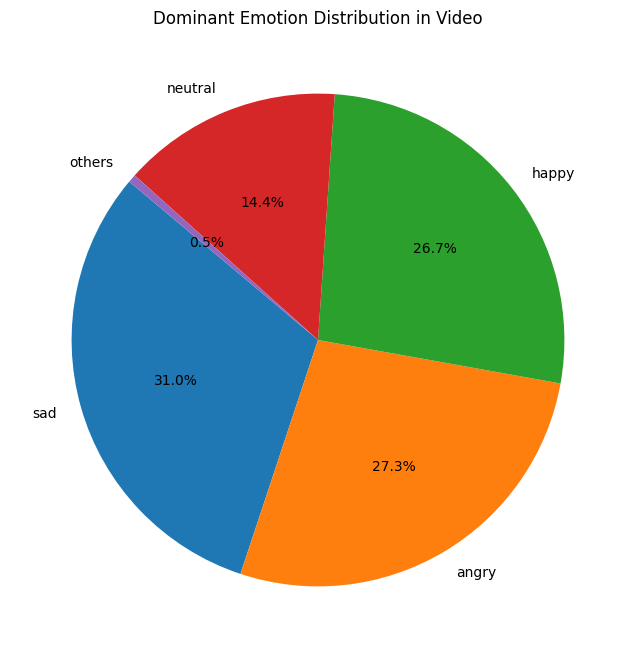

In [6]:
from collections import Counter
dominant_emotions = Counter(dominant_emotions)
plt.figure(figsize=(8, 8))
plt.pie(dominant_emotions.values(), labels=dominant_emotions.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dominant Emotion Distribution in Video')
plt.savefig('output/dominant_emotion_distribution_pie_chart.png', format='png', bbox_inches='tight')
plt.show()

### General

A human can change their facial interaction every 0.25 second, therefore the optimal is to take 4 frames per second, however, with more
frames there's more processing time, which means for the video TobyReturns, instead of 3 minutes, it will take 3 * 4 minutes, evidentally 12
minutes.

### Time Approximation

- *Processing*: cpu
- *Libraries loading*: 30 secs
- *Modules loading*: 2 mins
- *function loading*: 0.0 secs
- *Process_video loading on TobyReturns.mp4 & 1 frame*: 3 mins 